<a href="https://colab.research.google.com/github/satani99/generative_deep_learning/blob/main/03_variational_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch

In [2]:
# The Encoder
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()

    self.conv0 = nn.Conv2d(1, 32, kernel_size=3, stride=2)
    self.leaky_relu1 = nn.LeakyReLU(32)
    self.conv1 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
    self.leaky_relu2 = nn.LeakyReLU(64)
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
    self.leaky_relu3 = nn.LeakyReLU(64)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
    self.leaky_relu4 = nn.LeakyReLU(64)
    self.linear = nn.Linear(256, 2)

  def forward(self, x):
    x = self.conv0(x)
    x = self.leaky_relu1(x)
    x = self.conv1(x)
    x = self.leaky_relu2(x)
    x = self.conv2(x)
    x = self.leaky_relu3(x)
    x = self.conv3(x)
    x = self.leaky_relu4(x)
    x = torch.flatten(x, 1)
    output = self.linear(x.view(-1, 256))
    return output
              

In [3]:
encoder = Encoder()
print(encoder)

Encoder(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (leaky_relu1): LeakyReLU(negative_slope=32)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (leaky_relu2): LeakyReLU(negative_slope=64)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (leaky_relu3): LeakyReLU(negative_slope=64)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (leaky_relu4): LeakyReLU(negative_slope=64)
  (linear): Linear(in_features=256, out_features=2, bias=True)
)


In [4]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()

    self.linear = nn.Linear(2, 256)
    self.conv_t_0 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1)
    self.leaky_relu5 = nn.LeakyReLU(64)
    self.conv_t_1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1)
    self.leaky_relu6 = nn.LeakyReLU(64)
    self.conv_t_2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2)
    self.leaky_relu7 = nn.LeakyReLU(32)
    self.conv_t_3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, output_padding=1)
    self.leaky_relu8 = nn.LeakyReLU(1)

  def forward(self, x):
    x = self.linear(x)
    x = self.leaky_relu5(self.conv_t_0(x.view(32, 64, 2, 2)))
    x = self.leaky_relu6(self.conv_t_1(x))
    x = self.leaky_relu7(self.conv_t_2(x))
    x = self.leaky_relu8(self.conv_t_3(x))
    output = torch.sigmoid(x)
    return output
    

In [5]:
decoder = Decoder()
print(decoder)

Decoder(
  (linear): Linear(in_features=2, out_features=256, bias=True)
  (conv_t_0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (leaky_relu5): LeakyReLU(negative_slope=64)
  (conv_t_1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (leaky_relu6): LeakyReLU(negative_slope=64)
  (conv_t_2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (leaky_relu7): LeakyReLU(negative_slope=32)
  (conv_t_3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  (leaky_relu8): LeakyReLU(negative_slope=1)
)


In [6]:
tensor_transform = transforms.ToTensor()

dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)

loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,
                                     shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

# reshape = Reshape(32, 64, 2, 2)

In [8]:
class AE(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=2),
        nn.LeakyReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=2),
        nn.LeakyReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.LeakyReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.LeakyReLU(),
        nn.Flatten(),
        nn.Linear(256, 2)
    )
    self.decoder = nn.Sequential(
        nn.Linear(2, 256),
        Reshape(32, 64, 2, 2),
        nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, output_padding=1),
        nn.LeakyReLU(),
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [9]:
class AE_One(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 36),
        nn.ReLU(),
        nn.Linear(36, 18),
        nn.ReLU(),
        nn.Linear(18, 9)
    )

    self.decoder = nn.Sequential(
        nn.Linear(9, 18),
        nn.ReLU(),
        nn.Linear(18, 36),
        nn.ReLU(),
        nn.Linear(36, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28),
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


NameError: ignored

In [12]:
model = AE()

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [13]:
model.to(device)

AE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0.01)
    (8): ConvTranspose2d(32, 1, kernel_siz

In [15]:
epochs = 20
losses = []

for epoch in range(epochs):
  for (image, _) in loader:
    image = image.to(device)
    # image = image.reshape(1, -1, 28, 28)
    reconstructed = model(image)
    reconstructed = reconstructed.to(device)
    # print(image.shape)
    # print(reconstructed.shape)
    loss = loss_function(reconstructed, image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss)

# plt.style.use('fivethirtyeight')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')

# plt.plot(losses[-100:])


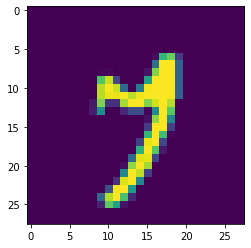

In [20]:
for i, item in enumerate(image):

# Reshape the array for plotting
  item = item.reshape(-1, 28, 28)
  item = item.cpu()
  plt.imshow(item[0])

# for i, item in enumerate(reconstructed):
#   item = item.reshape(-1, 28, 28)
#   # print(item.shape)
#   item = item.cpu()
#   plt.imshow(item[0].detach().numpy())


In [ ]:
print(model)

In [ ]:
model_1 = AE_One()

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model_1.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [ ]:
epochs = 20
losses = []

for epoch in range(epochs):
  for (image, _) in loader:

    image = image.reshape(-1, 28*28)
    reconstructed = model_1(image)
    # print(image.shape)
    # print(reconstructed.shape)
    loss = loss_function(reconstructed, image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss)

# plt.style.use('fivethirtyeight')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')

# plt.plot(losses[-100:])


In [ ]:
for i, item in enumerate(image):

# Reshape the array for plotting
  item = item.reshape(-1, 28, 28)
  plt.imshow(item[0])

for i, item in enumerate(reconstructed):
  item = item.reshape(-1, 28, 28)
  # print(item.shape)
  plt.imshow(item[0].detach().numpy())


In [ ]:
# to encode an image into a specific point z in the latent space 
# sample it from this distribution
# z = mu + sigma * epsilon
# where sigma = exp(log_var / 2)  log_var = log(sigma**2)
# epsilon is a point sampled from the standard normal distribution
